In [107]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c nlp-getting-started
# !mkdir data
# !unzip nlp-getting-started.zip -d /content/data

# # !rm -r ./data

**1. Importing Dependency**

In [108]:
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout,TextVectorization

import warnings
warnings.filterwarnings("ignore")

**2. Loading Dataset**

In [109]:
## using pandas read_csv funtion to load csv files
train = pd.read_csv("/content/data/train.csv")
test = pd.read_csv("/content/data/test.csv")
sample_submission  = pd.read_csv('/content/data/sample_submission.csv')

**3. Data processing**

In [110]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [111]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [112]:
print(f"test sahpe {test.shape}")
print(f"train sahpe {train.shape}")

test sahpe (3263, 4)
train sahpe (7613, 5)


In [113]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**4. Data cleaning**

In [115]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [116]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [117]:
train.location.value_counts().to_frame()

,location
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
"MontrÌ©al, QuÌ©bec",1
Montreal,1
"ÌÏT: 6.4682,3.18287",1
Live4Heed??,1


In [118]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)

  #removing HTML
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

  #removing hyperlink
  stripped_hyperlink = tf.strings.regex_replace(stripped_html,'https?://\S+|www\.\S+', '')

  #removing square brackets  
  stripped_square_brackets = tf.strings.regex_replace(stripped_hyperlink,'\[.*?\]', '')

  #removing puncuation
  stripped_puncuation = tf.strings.regex_replace(stripped_square_brackets,'[%s]' % re.escape(string.punctuation), '')
  stripped_puncuation = tf.strings.regex_replace(stripped_puncuation ,'\n' , '')

  #remove words containing numbers
  stripped_number = tf.strings.regex_replace(stripped_puncuation ,'\w*\d\w*' , '')


  return tf.strings.regex_replace(stripped_number,'[%s]' % re.escape(string.punctuation),'')
  


In [119]:
train['text'] = custom_standardization(train['text'])

In [120]:
max_features = 10000 # no of word in vocab
sequence_length = 250

**5. TextVectorization**

In [121]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [122]:
train['text'].values

array([b'our deeds are the reason of this earthquake may allah forgive us all',
       b'forest fire near la ronge sask canada',
       b'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
       ..., b'  s of volcano hawaii ',
       b'police investigating after an ebike collided with a car in little portugal ebike rider suffered serious nonlife threatening injuries',
       b'the latest more homes razed by northern california wildfire  abc news '],
      dtype=object)

In [123]:
vectorize_layer.adapt(train['text'].values)

In [124]:
vectorize_text = vectorize_layer(train['text'].values)
vectorize_text

<tf.Tensor: shape=(7613, 250), dtype=int64, numpy=
array([[ 108, 5945,   22, ...,    0,    0,    0],
       [ 176,   44,  210, ...,    0,    0,    0],
       [  40, 1671, 1625, ...,    0,    0,    0],
       ...,
       [ 209,    6,  540, ...,    0,    0,    0],
       [  76, 1057,   38, ...,    0,    0,    0],
       [   2,  193,   52, ...,    0,    0,    0]])>

In [125]:
X = vectorize_text
y = train['target']

**6. Defining model**

In [126]:
embedding_dim = 32

model = Sequential([
    Embedding(max_features + 1, embedding_dim),
    Bidirectional(LSTM(32, activation='tanh')),

    Dense(64,activation='relu'),
    Dropout(0.2),

    Dense(128,activation='relu'),
    Dropout(0.2),

    Dense(64,activation='relu'),
    Dropout(0.2),

    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [127]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320032    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

In [128]:
history = model.fit(X,y,epochs=10)

Epoch 1/10
238/238 [==============================] - 46s 174ms/step - loss: 0.5658 - accuracy: 0.7034
Epoch 2/10
238/238 [==============================] - 40s 170ms/step - loss: 0.3494 - accuracy: 0.8596
Epoch 3/10
238/238 [==============================] - 44s 183ms/step - loss: 0.2377 - accuracy: 0.9119
Epoch 4/10
238/238 [==============================] - 40s 170ms/step - loss: 0.1634 - accuracy: 0.9429
Epoch 5/10
238/238 [==============================] - 40s 170ms/step - loss: 0.1199 - accuracy: 0.9595
Epoch 6/10
238/238 [==============================] - 41s 173ms/step - loss: 0.0990 - accuracy: 0.9647
Epoch 7/10
238/238 [==============================] - 42s 176ms/step - loss: 0.0771 - accuracy: 0.9702
Epoch 8/10
238/238 [==============================] - 41s 171ms/step - loss: 0.0614 - accuracy: 0.9749
Epoch 9/10
238/238 [==============================] - 40s 170ms/step - loss: 0.0522 - accuracy: 0.9765
Epoch 10/10
238/238 [==============================] - 41s 172ms/step - l

**7. Checking accuracy**

In [129]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

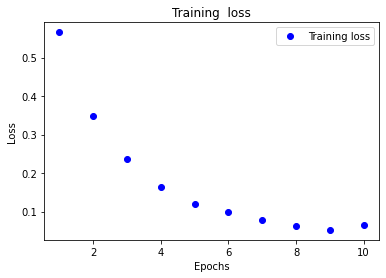

In [130]:
acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

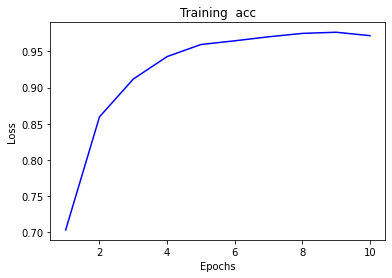

In [131]:
plt.title('Training  acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, acc, 'b', label='Validation loss')

**8. Testing**

In [132]:
test['text'] = custom_standardization(test['text'])

In [136]:
import random

random_num = random.randint(0,(3263-1))

data = test['text'][random_num]

# data = 'our deeds are the reason of this earthquake may allah forgive us all'
# # data = "what's up"

input_data = vectorize_layer(data)

predictions = model.predict(np.expand_dims(input_data,0))

print(data)
print(predictions)

b'im so over getting my hopes up and then being crushed'
[[0.00019634]]


In [137]:
value = predictions[0][0]
value > 0.5

False

In [138]:
if value>0.5 or value == 0.5 :
  print('Disaster Tweets')
elif value < 0.5:
  print('Not a Disaster Tweets')

Not a Disaster Tweets
